# Exploring and Predicting the existence of Kidney Stones

## Importing the necessary Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
from collections import Counter

## Loading the Image Dataset

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Path 
data_dir = "C:/Users/Farishtey/kidney_sampled"

# Create train and test generators using validation_split
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.25)  # 25% = 50 images if total is 200

train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

test_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=False  # Important to preserve order
)

Found 151 images belonging to 2 classes.
Found 49 images belonging to 2 classes.


In [3]:
# Show class labels
print("Class labels mapping:", train_generator.class_indices)

# Print class distribution
def print_class_distribution(generator, name):
    counts = Counter(generator.classes)
    print(f"\n{name} class distribution:")
    for label, count in counts.items():
        class_name = [k for k, v in generator.class_indices.items() if v == label][0]
        print(f"{class_name}: {count}")

# Print for both train and test
print_class_distribution(train_generator, "Train")
print_class_distribution(test_generator, "Test")

Class labels mapping: {'Normal': 0, 'Stoned': 1}

Train class distribution:
Normal: 83
Stoned: 68

Test class distribution:
Normal: 27
Stoned: 22


The dataset for both Train and Test is Balanced.

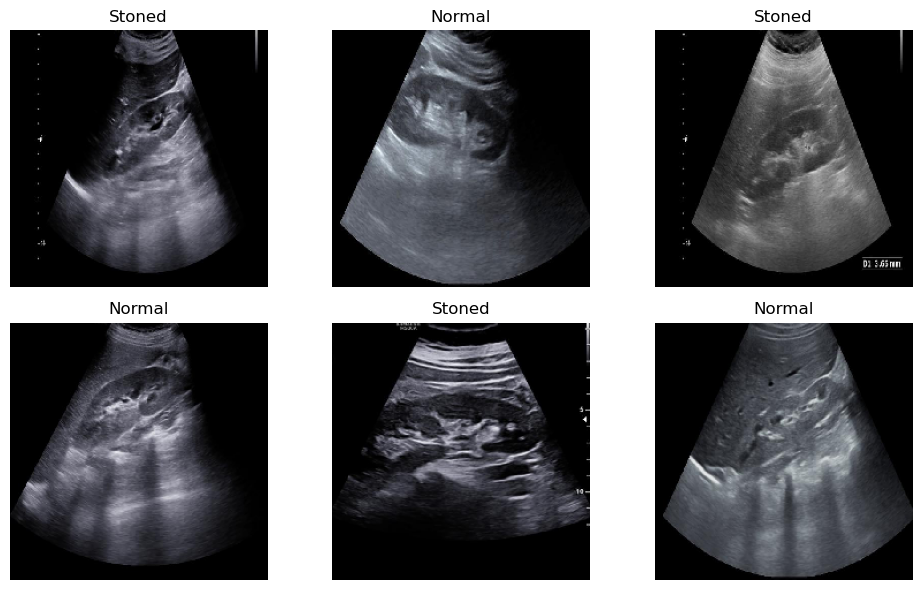

In [4]:
#Displaying some images (Train Dataset)
images, labels = next(train_generator)

# Plot first 6 images
plt.figure(figsize=(10, 6))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(images[i])
    plt.title('Stoned' if labels[i][1] == 1 else 'Normal')
    plt.axis('off')
plt.tight_layout()
plt.show()

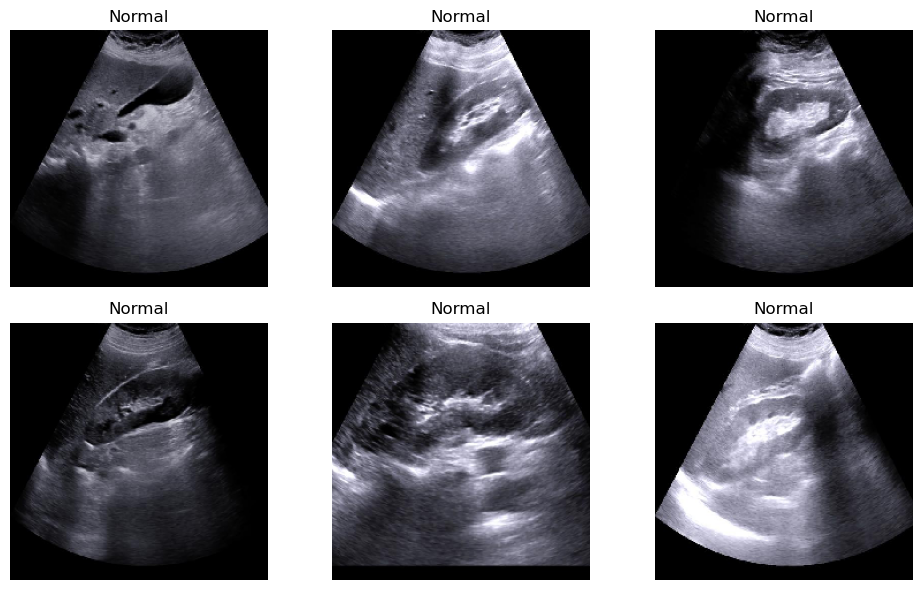

In [5]:
#Displaying some images (Testing Dataset)
images, labels = next(test_generator)

# Plot first 6 images
plt.figure(figsize=(10, 6))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(images[i])
    plt.title('Stoned' if labels[i][1] == 1 else 'Normal')
    plt.axis('off')
plt.tight_layout()
plt.show()

## EDA

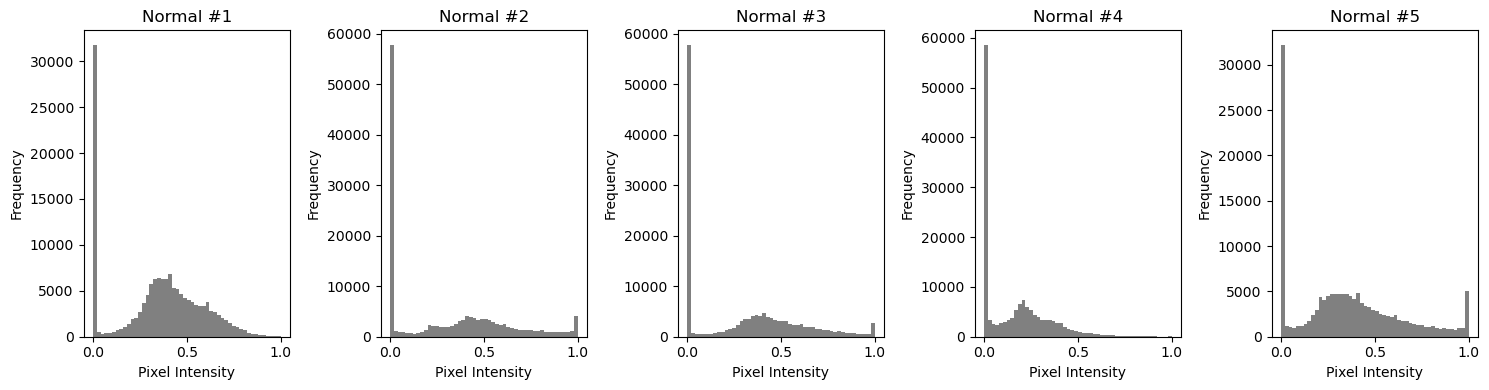

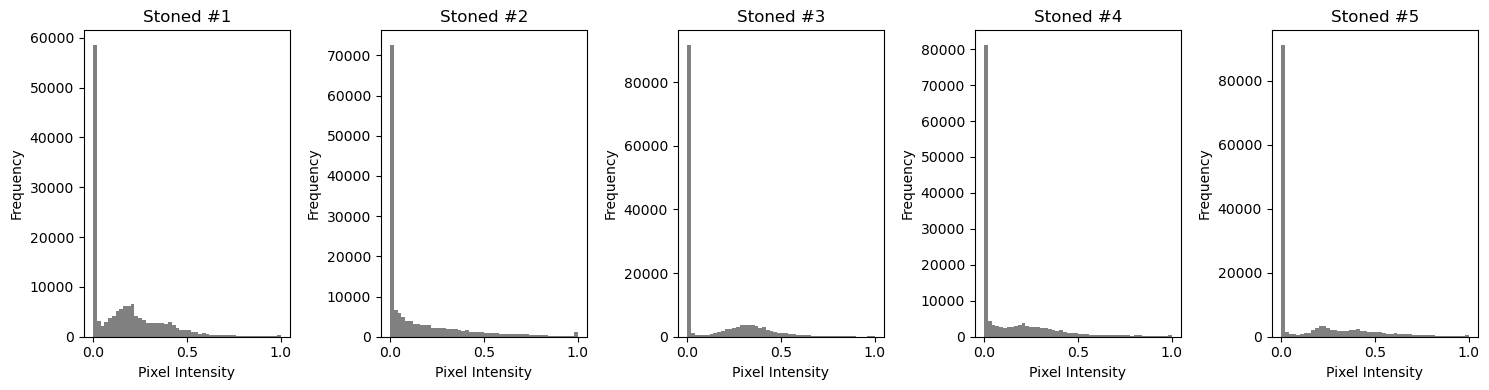

In [6]:
def plot_intensity_histograms(generator, label_index, label_name, num_samples=5):
    images, labels = next(generator)
    selected_images = [img for img, label in zip(images, labels) if np.argmax(label) == label_index][:num_samples]
    plt.figure(figsize=(15, 4))
    for i, img in enumerate(selected_images):
        plt.subplot(1, num_samples, i + 1)
        plt.hist(img.ravel(), bins=50, color='gray')
        plt.title(f"{label_name} #{i+1}")
        plt.xlabel("Pixel Intensity")
        plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

plot_intensity_histograms(train_generator, label_index=0, label_name='Normal')
plot_intensity_histograms(train_generator, label_index=1, label_name='Stoned')


The 'Stoned' images have darker regions on an average

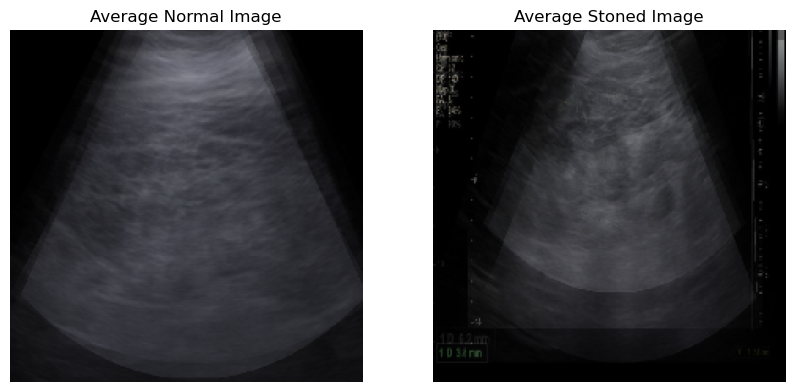

In [7]:
def compute_average_image(generator, label_index, num_images=50):
    images, labels = next(generator)
    selected_images = [img for img, label in zip(images, labels) if np.argmax(label) == label_index][:num_images]
    avg_image = np.mean(selected_images, axis=0)
    return avg_image

avg_normal = compute_average_image(train_generator, 0)
avg_stoned = compute_average_image(train_generator, 1)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(avg_normal)
plt.title("Average Normal Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(avg_stoned)
plt.title("Average Stoned Image")
plt.axis('off')
plt.show()


Extracted GLCM features shape: (200, 4)


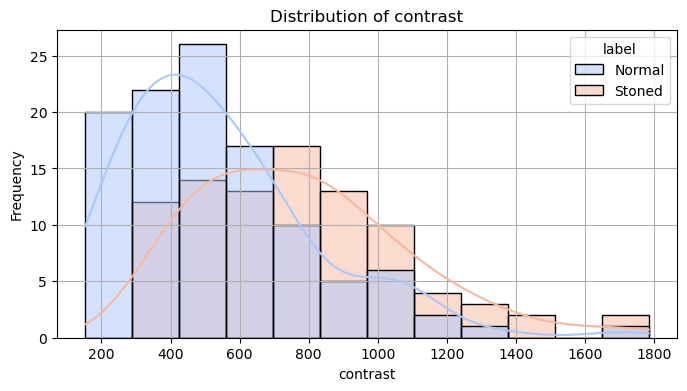

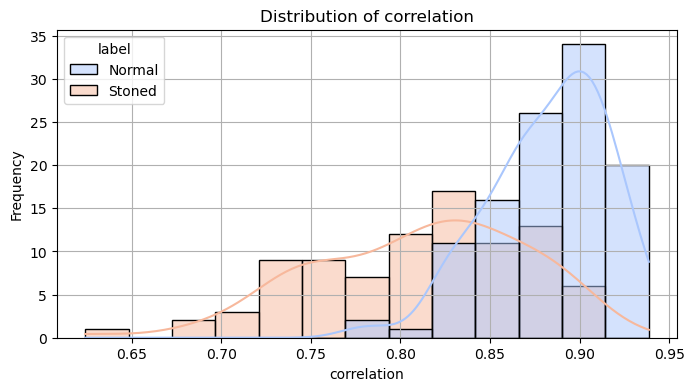

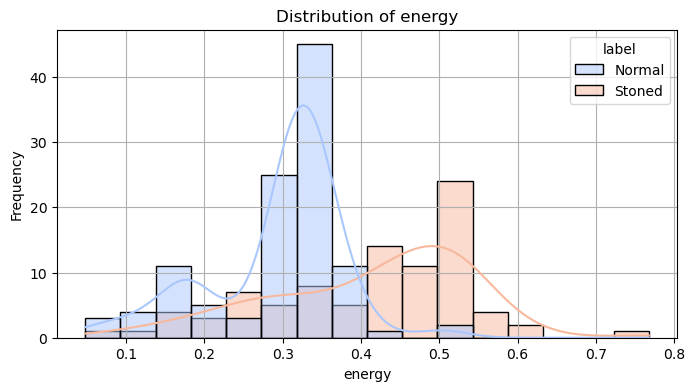

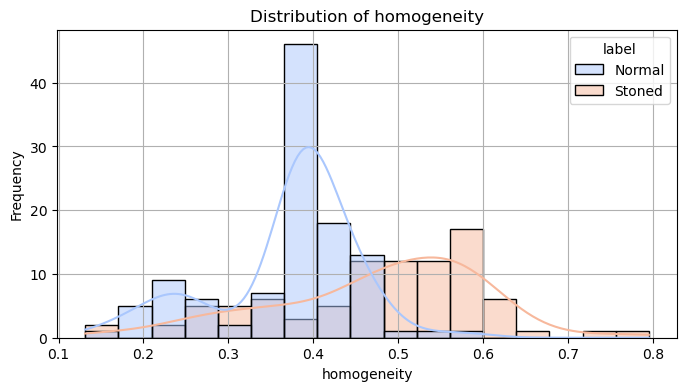

In [8]:
#GLCM (Gray Level Co-occurrence Matrix) is used to extract textural features
# from images by analyzing the spatial relationship between pixel intensities.
from skimage.feature import graycomatrix, graycoprops

# --- Step 1: Define function to extract GLCM features ---
def extract_glcm_features(image):
    
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # Compute GLCM
    glcm = graycomatrix(gray, distances=[5], angles=[0], levels=256, symmetric=True, normed=True)
    
    # Extract GLCM properties
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    correlation = graycoprops(glcm, 'correlation')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
    
    return [contrast, correlation, energy, homogeneity]

# --- Step 2: Load images and extract features ---
data_dir = "C:/Users/Farishtey/kidney_sampled"

# List of classes
class_names = os.listdir(data_dir)

X_features = []
y_labels = []

# Loop over classes
for label, class_name in enumerate(class_names):
    class_path = os.path.join(data_dir, class_name)
    
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        img = cv2.imread(img_path)
        img = cv2.resize(img, (224, 224))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Extract GLCM features
        features = extract_glcm_features(img)
        X_features.append(features)
        y_labels.append(label)

X_features = np.array(X_features)
y_labels = np.array(y_labels)

print(f"Extracted GLCM features shape: {X_features.shape}")

# --- Step 3: Create DataFrame for easy plotting ---
feature_names = ['contrast', 'correlation', 'energy', 'homogeneity']

df = pd.DataFrame(X_features, columns=feature_names)
df['label'] = y_labels
df['label'] = df['label'].map({0: 'Normal', 1: 'Stoned'})  # Adjust mapping if needed

# --- Step 4: Plot histograms for each GLCM feature ---
for feature in feature_names:
    plt.figure(figsize=(8,4))
    sns.histplot(data=df, x=feature, hue='label', kde=True, palette='coolwarm')
    plt.title(f"Distribution of {feature}")
    plt.xlabel(feature)
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()


GLCM properties:
 - Contrast: Measures local intensity variation (higher = more contrast)
 - Correlation: Measures how correlated a pixel is to its neighbor (higher = more similarity)
 - Energy: Measures textural uniformity (higher = more uniform texture)
 - Homogeneity: Measures closeness of elements to the diagonal in GLCM (higher = less contrast, smoother texture)


   bright_spot_count  bright_spot_area   label
0                  0                 0  Normal
1                 56              1090  Normal
2                 48               344  Normal
3                  1                 1  Normal
4                 42               610  Normal


C:\Users\Farishtey\AppData\Local\Temp\ipykernel_4388\3371589276.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='label', y='bright_spot_count', data=df, palette='coolwarm')


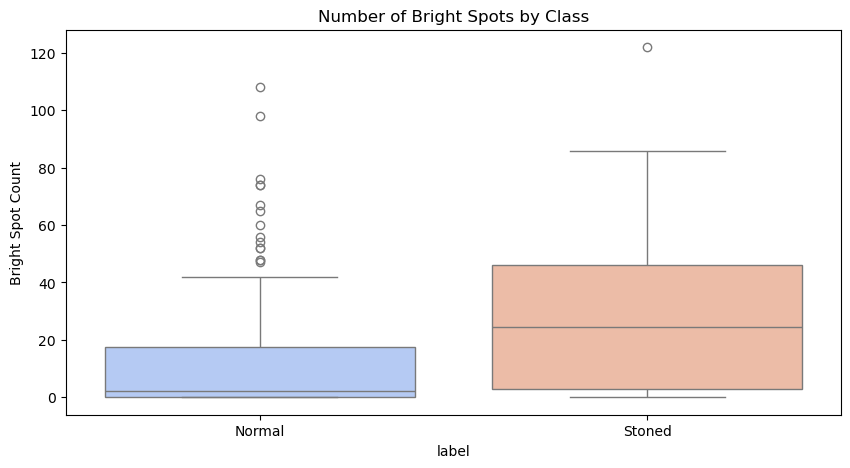

C:\Users\Farishtey\AppData\Local\Temp\ipykernel_4388\3371589276.py:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='label', y='bright_spot_area', data=df, palette='viridis')


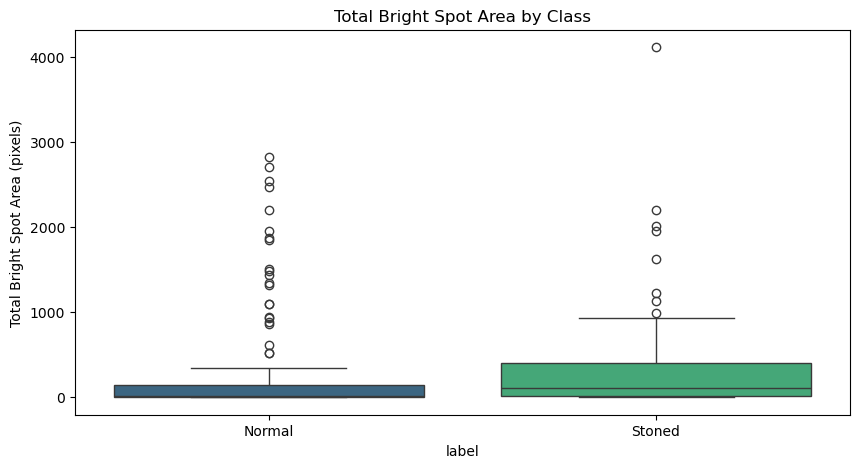

In [9]:
#Plotting the amount of bright white dots in the images 

# --- Step 1: Function to detect bright spots ---
def detect_bright_spots(image, bright_thresh=230):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # Threshold the bright spots
    _, binary = cv2.threshold(gray, bright_thresh, 255, cv2.THRESH_BINARY)
    
    # Find connected components (white blobs)
    num_labels, labels_im = cv2.connectedComponents(binary)
    
    # Ignore background (label 0)
    bright_spot_count = num_labels - 1
    
    # Optional: calculate total area of bright spots
    total_area = np.sum(binary > 0)
    
    return bright_spot_count, total_area

# --- Step 2: Load images and extract bright spot features ---
data_dir = "C:/Users/Farishtey/kidney_sampled"
class_names = os.listdir(data_dir)

features = []
labels = []

for label, class_name in enumerate(class_names):
    class_path = os.path.join(data_dir, class_name)
    
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        img = cv2.imread(img_path)
        img = cv2.resize(img, (224, 224))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        count, area = detect_bright_spots(img)
        features.append([count, area])
        labels.append(class_name)

# --- Step 3: Create DataFrame ---
df = pd.DataFrame(features, columns=['bright_spot_count', 'bright_spot_area'])
df['label'] = labels

print(df.head())

# --- Step 4: Plot distributions ---
plt.figure(figsize=(10, 5))
sns.boxplot(x='label', y='bright_spot_count', data=df, palette='coolwarm')
plt.title('Number of Bright Spots by Class')
plt.ylabel('Bright Spot Count')
plt.show()

plt.figure(figsize=(10, 5))
sns.boxplot(x='label', y='bright_spot_area', data=df, palette='viridis')
plt.title('Total Bright Spot Area by Class')
plt.ylabel('Total Bright Spot Area (pixels)')
plt.show()

The "Stoned" images on an average have a higher number of white bright spots.

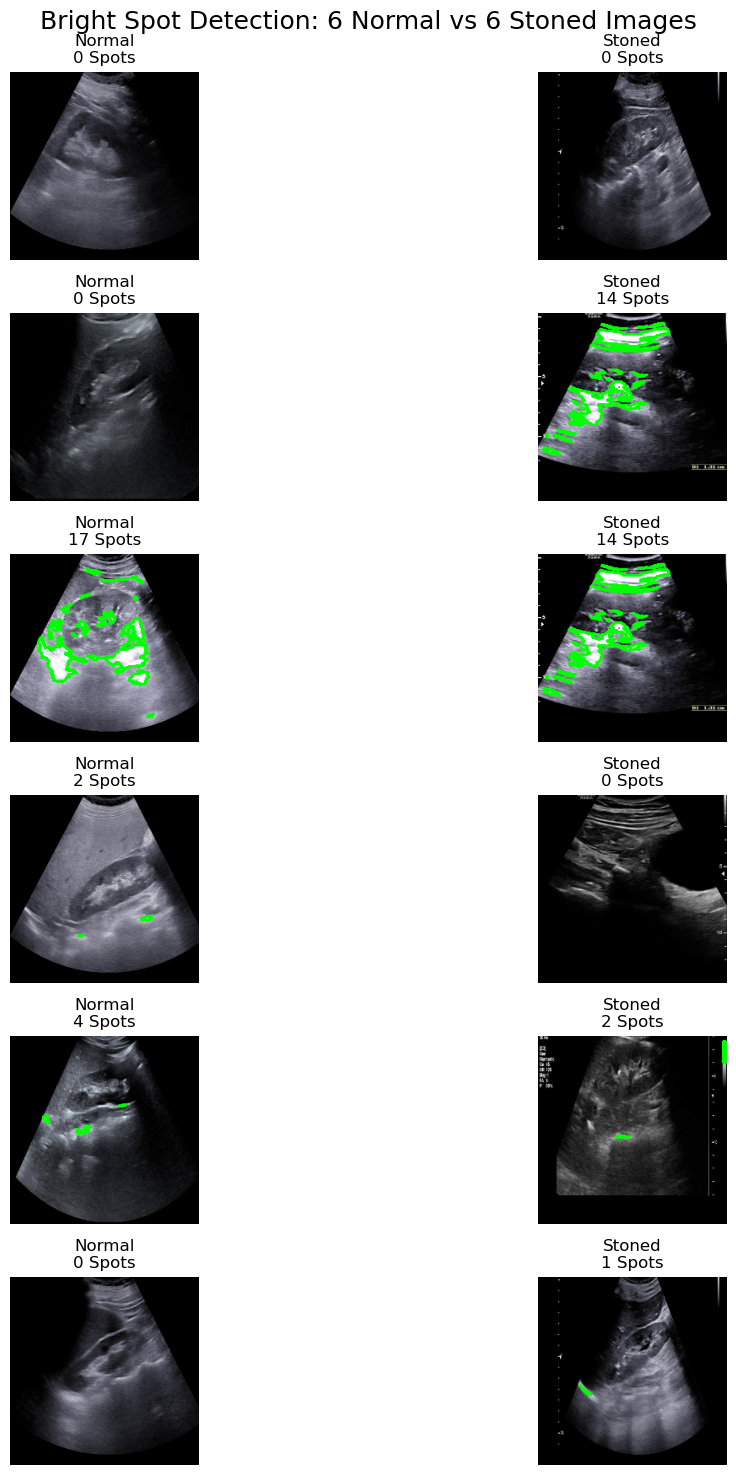

In [11]:
import random

def visualize_bright_spots(img, threshold_value=200, min_area=5):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    _, thresh = cv2.threshold(gray, threshold_value, 255, cv2.THRESH_BINARY)
    
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    overlay_img = img.copy()
    filtered_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > min_area]
    
    cv2.drawContours(overlay_img, filtered_contours, -1, (0,255,0), 2)
    
    return overlay_img, len(filtered_contours)

# Paths
normal_folder = "C:/Users/Farishtey/kidney_sampled/Normal/"
stoned_folder = "C:/Users/Farishtey/kidney_sampled/Stoned/"

# Collect all images
normal_images = [os.path.join(normal_folder, img) for img in os.listdir(normal_folder) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
stoned_images = [os.path.join(stoned_folder, img) for img in os.listdir(stoned_folder) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]

# Load and process function
def load_and_process(img_path):
    img = cv2.imread(img_path)
    if img is None:
        print(f"Image not found: {img_path}")
        return None, None
    img = cv2.resize(img, (224,224))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    overlay_img, bright_spot_count = visualize_bright_spots(img)  # <-- using your filtered version
    return overlay_img, bright_spot_count

num_samples = 6

# Create a grid figure
plt.figure(figsize=(14, num_samples * 2.5))

for i in range(num_samples):
    # Pick random images
    normal_img_path = random.choice(normal_images)
    stoned_img_path = random.choice(stoned_images)
    
    normal_overlay, normal_spots = load_and_process(normal_img_path)
    stoned_overlay, stoned_spots = load_and_process(stoned_img_path)
    
    if normal_overlay is not None:
        plt.subplot(num_samples, 2, i*2 + 1)
        plt.imshow(normal_overlay)
        plt.title(f"Normal\n{normal_spots} Spots")
        plt.axis('off')
    
    if stoned_overlay is not None:
        plt.subplot(num_samples, 2, i*2 + 2)
        plt.imshow(stoned_overlay)
        plt.title(f"Stoned\n{stoned_spots} Spots")
        plt.axis('off')

plt.suptitle('Bright Spot Detection: 6 Normal vs 6 Stoned Images', fontsize=18)
plt.tight_layout()
plt.show()


Inspite of white spots being a marker for Kidney Stones, "Normal" images also have regions of white that are due to certain fluids etc. 

Normal Images: Mean=4.92, Median=2.0, Min=0, Max=24
Stoned Images: Mean=5.90, Median=3.5, Min=0, Max=21


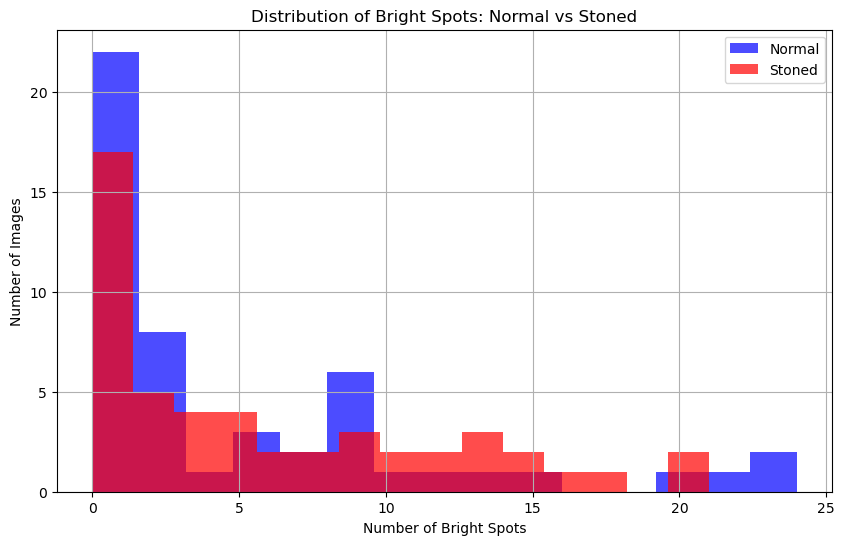

In [12]:
#Distribution of bright spots

num_samples = 50  

# Store results
normal_spot_counts = []
stoned_spot_counts = []

# Load and count function
def count_bright_spots(img_path):
    img = cv2.imread(img_path)
    if img is None:
        print(f"Image not found: {img_path}")
        return None
    img = cv2.resize(img, (224,224))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    _, bright_spot_count = visualize_bright_spots(img)
    return bright_spot_count

# Process normal images
for img_path in random.sample(normal_images, min(num_samples, len(normal_images))):
    spots = count_bright_spots(img_path)
    if spots is not None:
        normal_spot_counts.append(spots)

# Process stoned images
for img_path in random.sample(stoned_images, min(num_samples, len(stoned_images))):
    spots = count_bright_spots(img_path)
    if spots is not None:
        stoned_spot_counts.append(spots)

# ✨ Statistics
print(f"Normal Images: Mean={np.mean(normal_spot_counts):.2f}, Median={np.median(normal_spot_counts)}, Min={np.min(normal_spot_counts)}, Max={np.max(normal_spot_counts)}")
print(f"Stoned Images: Mean={np.mean(stoned_spot_counts):.2f}, Median={np.median(stoned_spot_counts)}, Min={np.min(stoned_spot_counts)}, Max={np.max(stoned_spot_counts)}")

# 📊 Plot histogram
plt.figure(figsize=(10,6))
plt.hist(normal_spot_counts, bins=15, alpha=0.7, label='Normal', color='blue')
plt.hist(stoned_spot_counts, bins=15, alpha=0.7, label='Stoned', color='red')
plt.xlabel('Number of Bright Spots')
plt.ylabel('Number of Images')
plt.title('Distribution of Bright Spots: Normal vs Stoned')
plt.legend()
plt.grid(True)
plt.show()


## Model Building

In [13]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Model architecture
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)),
    MaxPooling2D(2,2),
    
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')  # 2 classes: Normal and Stoned
])

# Compile
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Summary
model.summary()

# Train
history = model.fit(
    train_generator,
    epochs=15,
    validation_data=test_generator
)

# Evaluate
loss, acc = model.evaluate(test_generator)
print(f"Test Accuracy: {acc*100:.2f}%")


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 128)       0

## Evaluating the performance of the model

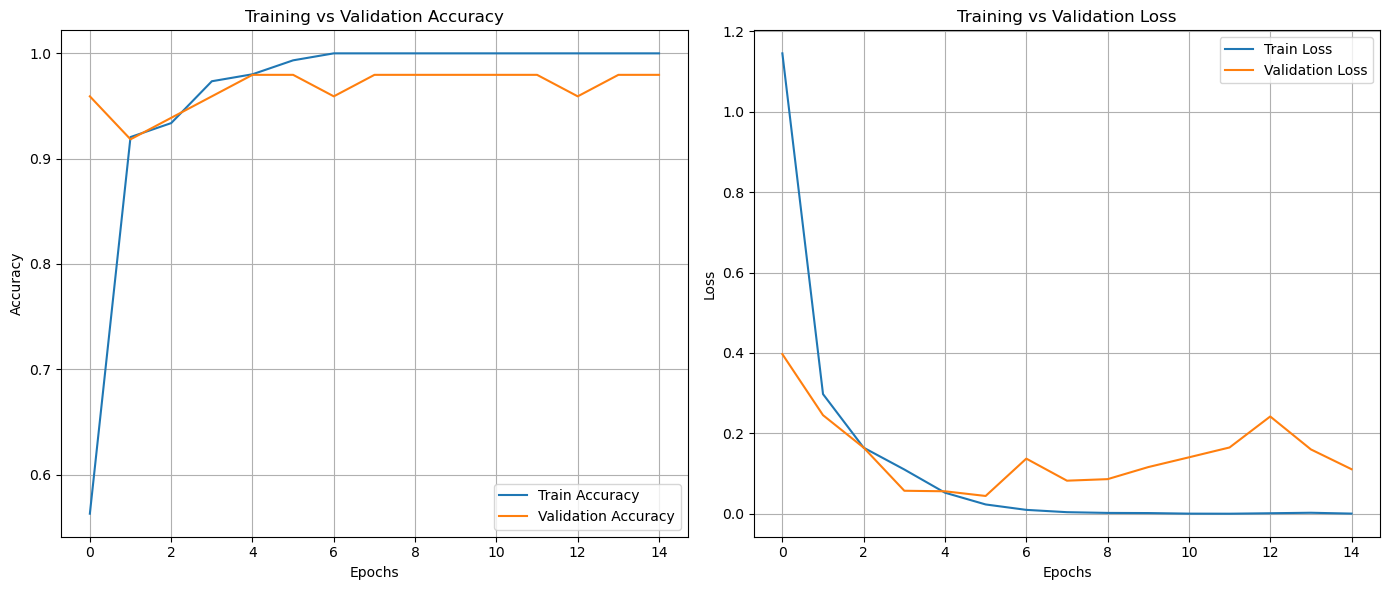

In [14]:
# Plotting Training Curves

# Accuracy
plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


2/2 [==============================] - 1s 235ms/step


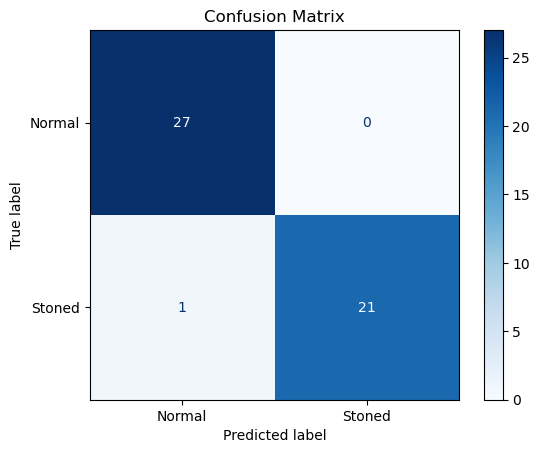

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get true labels and predictions
true_labels = test_generator.classes
class_names = list(test_generator.class_indices.keys())

# Predict
pred_probs = model.predict(test_generator)
pred_labels = np.argmax(pred_probs, axis=1)

# Confusion Matrix
cm = confusion_matrix(true_labels, pred_labels)

# Display
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


In [16]:
from sklearn.metrics import classification_report

# Already predicted earlier:
# true_labels = test_generator.classes
# pred_labels = np.argmax(model.predict(test_generator), axis=1)

# Class names
class_names = list(test_generator.class_indices.keys())

# Generate report
report = classification_report(true_labels, pred_labels, target_names=class_names)

print("Classification Report:\n")
print(report)

Classification Report:

              precision    recall  f1-score   support

      Normal       0.96      1.00      0.98        27
      Stoned       1.00      0.95      0.98        22

    accuracy                           0.98        49
   macro avg       0.98      0.98      0.98        49
weighted avg       0.98      0.98      0.98        49

